In [3]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# Introduction

Ce notebook vise à présenter l'évolution d'un TVAR(2) en fonction du choix de T qui définit l'intervalle entre deux mesures du processus sur l'intervalle [0,1].

Rappelons que nous définissons le TVAR(2) comme suit $\forall t$ dans $[0,1]$:

\begin{equation}
X_{t,T} = a_1(\frac{t}{T})X_{t-1,T} + a_2(\frac{t}{T})X_{t-2,T} + \sigma(\frac{t}{T})\epsilon_{t,T}
\end{equation}

Avec $\epsilon_{t,T}$ un bruit blanc centré de variance 1.
Dans la suite, pour simplifier les expressions, on prendra $\sigma(u)=1$ sur $[0,1]$.

# Premier exemple

Prenons le polynôme caractéristique avec $\forall u$ dans $[0,1]$:
    \begin{equation}
    A(z;u) = 1 - a_1(u) z - a_2(u) z^2
    \end{equation}

Pour le cas $p=2$, il est facile de choisir des coefficients pour le TVAR puisqu'on a les relations coefficients/racines suivantes lorsque l'on note $z_1$ et $z_2$ les racines du polynome $az^2 + bz + 1$:
\begin{equation}
a = \frac{1}{z_1 z_2}
\end{equation}
\begin{equation}
b = -\frac{z_1 + z_2}{z_1 z_2}
\end{equation}

Donc en choisissant les racines variant au cours du temps $u$ dans $[0,1]$ $z_1(u) = u - \frac{1}{2}$ et $z_2(u) = \frac{1}{3} \sin(2 \pi u)$ (on vérifie bien la condition que $|z| < 1$), on a les coefficients : 

Avec $\forall u$ dans $[0,1]$:
    \begin{equation}
    a_1(u) = -\frac{\frac{1}{3}(u+ \sin(2\pi u))}{(u-\frac{1}{2}) \sin(2 \pi u)}
    \end{equation}
    \begin{equation}
    a_2(u) = \frac{1}{(\frac{1}{3}u-\frac{1}{2})(\frac{1}{2} + \frac{1}{3}\sin(2 \pi u))}
    \end{equation}

In [4]:
epsilon = np.random.randn(int(2e4))

### T = 100

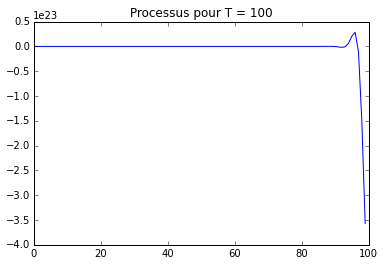

In [12]:
T = 100
X = np.zeros(2*T)
a_1 = np.zeros(2*T)
a_2 = np.zeros(2*T)

u = np.arange(T, dtype='double')/T

a_1[T:2*T] = (u + np.sin(2 * np.pi * u)) / (3* (1./3 * u-0.5) * (0.5 + 1./3 * np.sin(2 * np.pi * u)))
a_2[T:2*T] = 1. / ((1./3 * u-0.5) * (0.5 + 1./3 * np.sin(2 * np.pi * u)))
    
X[0] = epsilon[0]
X[1] = epsilon[100]
    
for n in np.arange(2*T-2):
    X[n+2] = a_1[n+2]*X[n-1] + a_2[n+2]*X[n-2] + epsilon[(n+2)*100]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], X[T:2*T])
plt.title("Processus pour T = 100")

### T = 1000

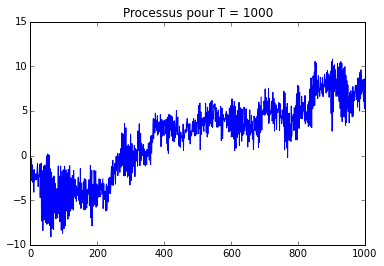

In [5]:
T = 1000
X = np.zeros(2*T)
a_1 = np.zeros(2*T)
a_2 = np.zeros(2*T)


a_1[T:2*T] = np.arange(T, dtype = 'double') / T
a_2[T:2*T] = a_1[T:2*T][::-1]
    
X[0] = epsilon[0]
X[1] = epsilon[10]
    
for n in np.arange(2*T-2):
    X[n+2] = a_1[n+2]*X[n-1] + a_2[n+2]*X[n-2] + epsilon[(n+2)*10]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], X[T:2*T])
plt.title("Processus pour T = 1000")

###T = 10000

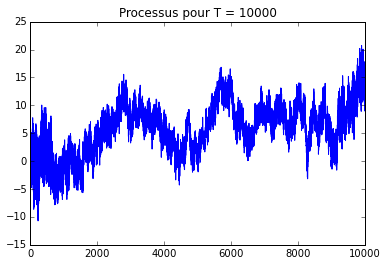

In [6]:
T = 10000
X = np.zeros(2*T)
a_1 = np.zeros(2*T)
a_2 = np.zeros(2*T)

a_1[T:2*T] = np.arange(T, dtype = 'double') / T
a_2[T:2*T] = a_1[T:2*T][::-1]
    
X[0] = epsilon[0]
X[1] = epsilon[1]
    
for n in np.arange(2*T-2):
    X[n+2] = a_1[n+2]*X[n-1] + a_2[n+2]*X[n-2] + epsilon[n+2]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], X[T:2*T])
plt.title("Processus pour T = 10000")

Trovuer les coefficients qui vont bien :
- relations coefficients racine
- algo de levinson pour trouver les coefficients AR à partir des coefficients de corrélation (relations par récurrence, avec des coeff causaux, continus... ; trouver $\kappa=f(\Phi)$)

Dans le cas de levinson, prendre une matrice de correaltion et pas d'autocovariance pour assurer la stabilité.

Trouver une implémentation de $\hat\theta$ et de sa DSP en fonction de $\lambda$ et de $t$.

Faire une simulation avec des coeff complexes conjugués avec animation de la DSP. La puissance se trouve là où $\lambda$ = angle($\phi$).

Trouver ensuite sur les exemples le comportement de $\mu$ (terme de variance dans le théorème 2) et comprendre son influence.

# Deuxième exemple

On va maintenent se servir d'un géné d'AR puis de TVAR à partir des équations de Yule et Walker ainsi que de l'algorithme de Levinson - Durbin.

Pour se faire, on génère des matrice de corrélation pour chaque échantillon de $X_t$ puis on trovue les prédicteurs associés. Prendre une matrice de corrélations et non de convariances assure que le polynome caractéristique du processus obtenu est bien celui d'un processus AR/TVAR stable.


In [31]:
from scipy.linalg import toeplitz, pinv

def generation_TVAR(d, T):
    """ generation d'un vecteur de taille 2T dont le zéro se situe à l'indice T"""
    X = np.zeros(2*T)
    theta = np.matrix((d, T))
    
    for t in np.arange(T):
        gamma = 2 * np.random.rand(d) - 1 #prennd des valeurs entre 61 et 1
        Gamma = np.matrix(toeplitz(gamma))
        L = np.matrix(np.zeros((d,1)))
        L[0,0] = 1
        theta[:,t] = - pinv(Gamma) * L
        X[t] = X[t-1:-1:t-d] * theta[:,t]
        
    return X, theta

X, theta = generation_TVAR(2, 10)

ValueError: could not broadcast input array from shape (2,1) into shape (1,1)

# Construction de l'estimateur

Dans cette partie, on cherche à construire un estimateur du vecteur $\theta_T$ qui contient les coefficients du polynome caractéristique du processus TVAR pour une fenêtre d'observation des échantillons de période $T$.

Pour ce faire, on le construit grâce à un algorithme en ligne de type NLMS avec un pas de descente de gradient de $\mu$.

In [29]:
from scipy.linalg import norm

d = 2
T = 10000
mu = 1e-2

theta_est = np.matrix(d,T)
X_est = np.zeros(2*T)
X = generation_TVAR(d, T)

for k in (np.arange(T)):
    XX = X[k-1:-1:k-d]
    theta_est = theta_est + mu * (X[k] - np.dot(theta_est, XX)) * XX / (1 + mu * norm(XX) ** 2)  
    X_est[T+k] = np.dot(X_est[T+k-1:-1:T+k-d], theta_est)

TypeError: data type not understood

On va maintenant calculer la DSP du processus réel $X_t$ déterminé par l'algorithme de Levinson-Durbin ainsi que celle du processus estimé $\hat X_t$ obtenu à partir de $\hat\theta_n$.

In [15]:
from scipy.fftpack import fft

N = 512

def dsp(theta,T, N = 512):
    dsp_array = np.zeros((N, T))
    
    for t in np.arange(T):
        dsp_array[:,t] = (1./abs(fft(theta, N)) ** 2).T
        
    return dsp_array

dsp_X = dsp(tetha, T)
dsp_X_est = dsp(theta_est, T)

lambd = np.arange(-N, N, 1, dtype = 'double') / N

plt.plot(lambd, dsp_X, 'r', label ='vraie DSP')
plt.plot(lambd, dsp_X_est, 'b', label = 'DSP estimee')
plt.title("Comparaison des DSP")